<h1>Baseline Tests</h1>

Conduct simple proof-of-concept test to verify the correctness of algorithmic implementations for the following algorithms: 

1. NSR (no swap regrets)
1. RL (reinforcement learning)

### imports

In [1]:
import sys, os 
import numpy as np
sys.path.append(os.path.abspath(".."))
from market_core import DuopolyEnv 
import matplotlib.pyplot as plt
import seaborn as sns
from utils import run_episode
from agent_zoo import NSRAgent, FixedPriceAgent, RandomAgent

In [14]:
def get_best_response(p2_values, env_config):
    """
    Calculates the best response p1 for a given set of p2 values (scalar or array).
    """
    # 1. Setup Grid
    p1_range = np.linspace(0, env_config['max_price'], 1000)
    c1 = env_config['production_costs'][0]
    q1, q2 = env_config['quality']
    mu = env_config['price_sensitivity']
    
    # 2. Vectorized Calculation
    # We need to broadcast p1_range against p2_values if p2 is an array
    # p1_range: [1000], p2_values: [Steps]
    # Result: [1000, Steps]
    
    p2_values = np.atleast_1d(p2_values)
    
    # Utilities
    # U1 [1000, 1]
    u1 = q1 - mu * p1_range[:, np.newaxis]
    # U2 [1, Steps]
    u2 = q2 - mu * p2_values[np.newaxis, :]
    
    # Shares
    exp_u1 = np.exp(u1)
    exp_u2 = np.exp(u2)
    # Denom [1000, Steps]
    denom = 1.0 + exp_u1 + exp_u2
    shares1 = exp_u1 / denom
    
    # Profits [1000, Steps]
    profits1 = (p1_range[:, np.newaxis] - c1) * shares1
    
    # Find max index for each step
    best_indices = np.argmax(profits1, axis=0)
    best_p1_array = p1_range[best_indices]
    
    return best_p1_array
def plot_generalized_convergence(df_history, env_config, title_suffix=""):
    """
    Plots the agent's price vs the instantaneous best response to the opponent.
    """
    # 1. Calculate Instantaneous Best Response (Target)
    target_p1 = get_best_response(df_history['p2'].values, env_config)
    
    # 2. Plot
    plt.figure(figsize=(14, 7))
    
    # Agent Price
    plt.plot(df_history['step'], df_history['p1'], 
             label='NSR Agent Price', color='blue', linewidth=1.5, alpha=0.8)
    
    # Target Price (Best Response)
    plt.plot(df_history['step'], target_p1, 
             label='Instantaneous Best Response (Target)', 
             color='red', linestyle='--', linewidth=1.5, alpha=0.6)
    
    # Opponent Price (for context)
    plt.plot(df_history['step'], df_history['p2'], 
             label='Opponent Price', color='gray', linestyle=':', alpha=0.3)
    
    plt.title(f'Agent Convergence Analysis {title_suffix}')
    plt.xlabel('Step')
    plt.ylabel('Price ($p_1$)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Add Moving Average for clearer trend if noisy
    if len(df_history) > 50:
        ma_p1 = df_history['p1'].rolling(window=20).mean()
        plt.plot(df_history['step'], ma_p1, color='blue', linewidth=2, label='NSR Price (MA-20)')
    
    plt.show()


## Static Market

Market inputs: 

1. demand std: 0
1. price sensitivity: 0.8
1. max price: 10 
1. firm 1 cost: 1 
1. firm 2 cost: 2 
1. brand quality: 2.0 for both 

In [15]:
env_config = {
    'market_mode': 'static',
    'production_costs': [1.0, 2.0],
    'quality': [2.0, 2.0],
    'price_sensitivity': 0.8, # Back to standard sensitivity
    'max_price': 10.0,
    'cost_std': 0.0,
    'max_steps': 1000
} 
nsr_config = {
    'n_bins': 100,
    'learning_rate': 0.1,
    'quality': 2.0,           # Must match env
    'price_sensitivity': 0.8, # Must match env
    'cost': 1.0               # Agent 1's cost
}
fixed_config = {'fixed_price':2.5}
random_config = {'max_price':10.0}

In [16]:
env = DuopolyEnv(config=env_config)
nsr_agent = NSRAgent(action_space=env.action_space,config=nsr_config)
fixed_agent = FixedPriceAgent(action_space=env.action_space,config=fixed_config)
random_agent = RandomAgent(action_space=env.action_space,config=random_config)

/Users/alanwu/Documents/GitHub/cis-6200-final/venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/alanwu/Documents/GitHub/cis-6200-final/venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### NSR (No Swap Regret)

In [17]:
nsr_fixed_history = run_episode(env, nsr_agent, fixed_agent, label='NSR vs Fixed')
nsr_random_history = run_episode(env, nsr_agent, random_agent, label="NSR vs Random")

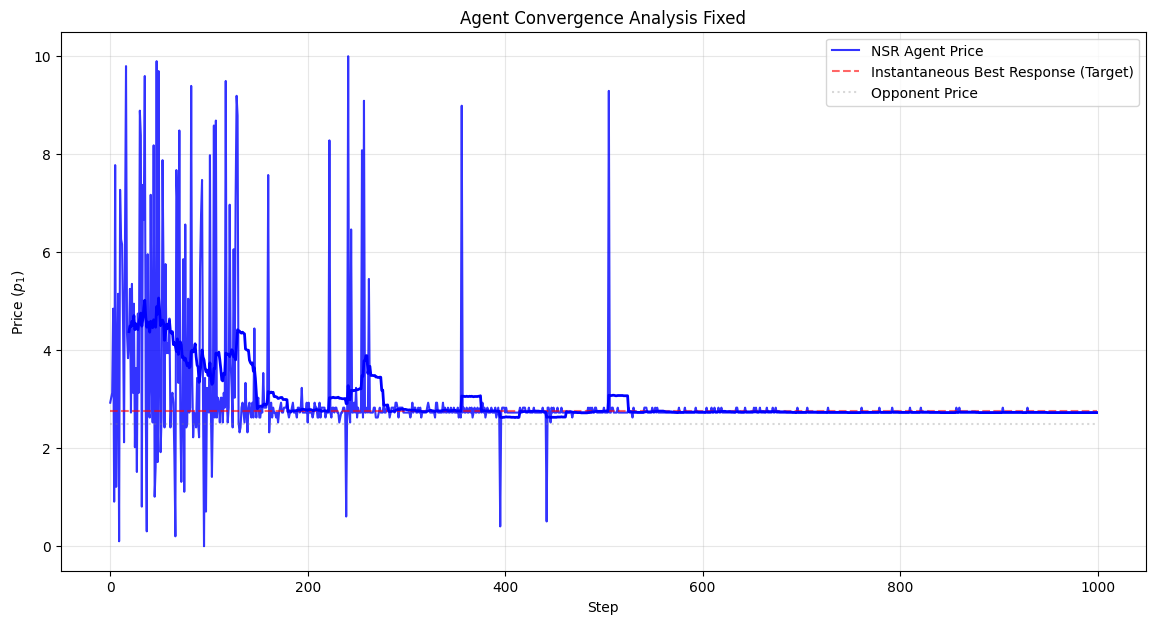

In [18]:
plot_generalized_convergence(nsr_fixed_history, env_config, title_suffix="Fixed")

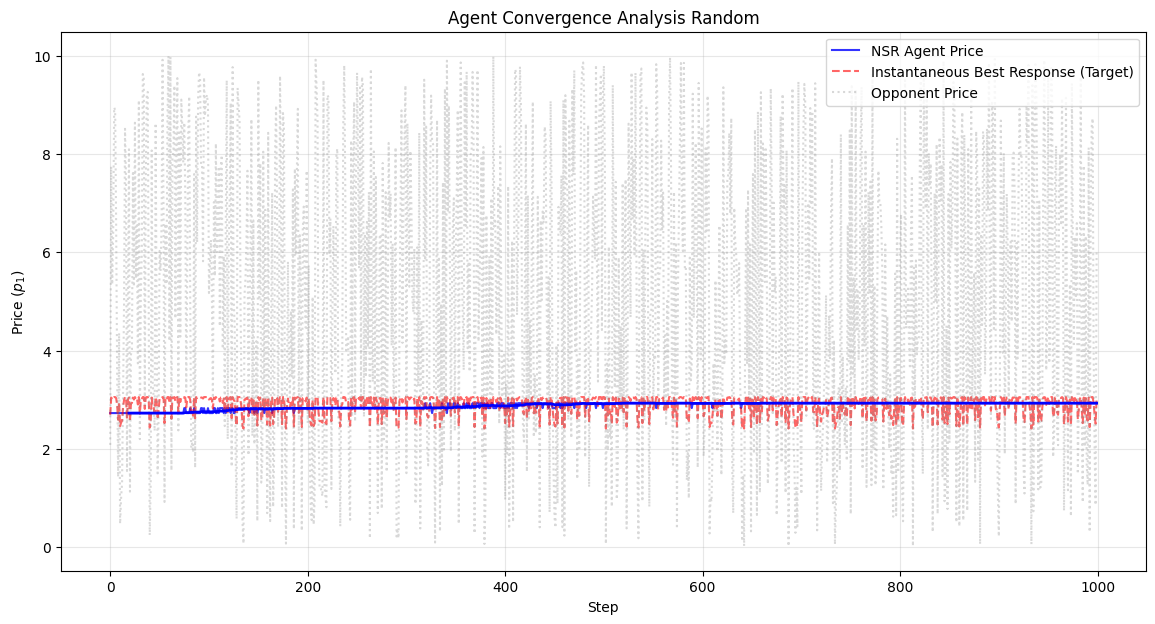

In [19]:
plot_generalized_convergence(nsr_random_history, env_config, title_suffix="Random")

In [ ]:
plot_nsr_convergence(nsr_)

Constant Pricing Agent